In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
from aps_ai.beamline34IDC.optimization import movers, configs, display_utils, common as opt_common
from aps_ai.beamline34IDC.optimization.scipy_nelder_mead import ScipyOptimizer
from aps_ai.beamline34IDC.optimization.skopt_gp import SkoptGaussianProcessOptimizer, SkoptDiscreteGPOptimizer
import beamline34IDC.optimization.movers as movers

from aps_ai.beamline34IDC.optimization.display_utils import LivePlotCallback
from aps_ai.beamline34IDC.util import clean_up
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import IPython
from skopt.callbacks import DeltaXStopper, DeltaYStopper, DeadlineStopper
from pathlib import Path
import optuna

In [3]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

94812


In [4]:
base_dir = Path('/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/')
orig_work_dir = base_dir /'work_directory'
temp_work_dir = base_dir / f'tmp_work_dir_{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [5]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [6]:
os.chdir(temp_work_dir)

In [7]:
input_beam_path = "primary_optics_system_beam.dat"

In [8]:
move_motors = ['hkb_1', 'vkb_1', 'hkb_2', 'vkb_2', 'hkb_3', 'vkb_3', 'hkb_4', 'vkb_4']

In [9]:
motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

In [10]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)

In [11]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

[0.2500515 0.1425    0.1570341 0.2995    3.        3.        0.
 0.       ]


In [12]:
class OptunaOptimizer(opt_common.OptimizationCommon):
    """"""
    opt_platform = 'optuna'
    
    def loss_function(self, translations: list, verbose: bool = True) -> float:
        """This mutates the state of the focusing system."""

        self.focusing_system = movers.move_motors(self.focusing_system, self.motor_types, translations,
                                                  movement='relative')
        self._update_beam_state()

        loss = [lossfn() for lossfn in self._loss_function_list]

        self._opt_trials_motor_positions.append(translations)
        self._opt_trials_losses.append(loss)
        self._opt_fn_call_counter += 1
        if verbose:
            print("motors", self.motor_types, "trans", translations, "current loss", loss)
        return loss
    
    def objective(self, trial):
        translations = []
        for mt, r in zip(self.motor_types, self.motor_ranges):
            translations.append(trial.suggest_float(mt, r[0], r[1]))
        loss_this = self._lossfn_this(translations)
        return loss_this
    
    def trials(self, n_guesses = 1, verbose: bool = False, accept_all_solutions: bool = False):
        pass
    
    def _optimize(self):
        pass
    def set_optimizer_options(self):
        pass
    
    def get_random_init(self, guess_range = None, verbose=True):
        if guess_range is None:
            guess_range = [np.array(configs.DEFAULT_MOVEMENT_RANGES[mt]) / 2 for mt in self.motor_types]
        elif np.ndim(guess_range) == 1 and len(guess_range) == 2:
            guess_range = [guess_range for mt in self.motor_types]
        elif np.ndim(guess_range) != 2 or len(guess_range) != len(self.motor_types):
            raise ValueError("Invalid range supplied for guesses.")

        initial_guess = [np.random.uniform(m1, m2) for (m1, m2) in guess_range]
        lossfn_obj_this = self.TrialInstanceLossFunction(self, verbose=verbose)
        guess_loss = lossfn_obj_this.loss(initial_guess, verbose=False)
        if verbose:
            print('Random guess', initial_guess, 'has loss', guess_loss)
        
        while np.sum(guess_loss) >= self._no_beam_loss or np.isnan(np.sum(guess_loss)):
            self.reset()
            if verbose:
                print("Random guess", initial_guess, "produces beam out of bounds. Trying another guess.")
            initial_guess = [np.random.uniform(m1, m2) for (m1, m2) in guess_range]
            if verbose:
                print('Random guess is', initial_guess)
            guess_loss = lossfn_obj_this.loss(initial_guess, verbose=False)
        return initial_guess
    
    

In [13]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

In [14]:
opt_trial = OptunaOptimizer(focusing_system, 
                                              motor_types=move_motors, 
                                              random_seed=DEFAULT_RANDOM_SEED, 
                                              loss_parameters=['centroid', 'fwhm'],
                                              loss_min_value=5e-4,
                                              use_gaussian_fit=False)

In [15]:
init_range = np.array([[-0.02, 0.02], [-0.02, 0.02], [-0.02, 0.02], [-0.02, 0.02], [-0.01, 0.01],[-0.01, 0.01], [-0.01, 0.01], [-0.01,0.01]])

In [16]:
absolute_movements = []

Random guess [0.01865683273025667, -0.00459177053707939, 0.015833659751491553, 0.012198419963868685, 0.00307087919835013, -0.0032535707211409862, -0.004033056384136618, -0.007487281657456952] has loss [0.006049413434061423, 0.009433102762704914]


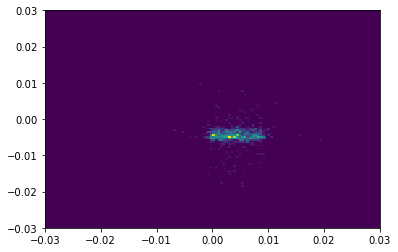

In [17]:
random_inits = opt_trial.get_random_init(guess_range=init_range)
    


absolute_movements.append(initial_absolute_positions + random_inits)

beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED, xrange=[-0.03, 0.03], yrange=[-0.03, 0.03], nbins=128)
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)
plt.show()

In [18]:
opt_common.get_sigma(focusing_system), opt_common.get_fwhm(focusing_system)

(BeamParameterOutput(parameter_value=0.0035032606230333513, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x2b9c3abf7cd0>, hist=<beamline34IDC.util.shadow.common.ShadowHistogram object at 0x2b9c3b0b3d10>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x2b9c3b0b3a90>),
 BeamParameterOutput(parameter_value=0.00900208248391488, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x2b9c3ad9bb50>, hist=<beamline34IDC.util.shadow.common.ShadowHistogram object at 0x2b9c3b0b3b10>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x2b9c3b0ed950>))

In [19]:
dw._DictionaryWrapper__dictionary

{'h_sigma': 0.0029522037855001454,
 'h_fwhm': 0.008906249999999942,
 'h_centroid': 0.0040470035442222935,
 'v_sigma': 0.00217496153826202,
 'v_fwhm': 0.0009374999999999939,
 'v_centroid': -0.0045021657811574346,
 'integral_intensity': 521.2730277270376,
 'peak_intensity': 8.385864730724432,
 'gaussian_fit': {}}

In [20]:
 dw.get_parameter('v_fwhm') / dw.get_parameter('v_sigma')

0.4310421051165514

In [21]:
random_inits

[0.01865683273025667,
 -0.00459177053707939,
 0.015833659751491553,
 0.012198419963868685,
 0.00307087919835013,
 -0.0032535707211409862,
 -0.004033056384136618,
 -0.007487281657456952]

In [22]:
opt_trial.motor_ranges = init_range

In [23]:
opt_trial._lossfn_obj_this = opt_trial.TrialInstanceLossFunction(opt_trial, verbose=False)
opt_trial._lossfn_this = opt_trial._lossfn_obj_this.loss

In [24]:
study = optuna.create_study(directions=['minimize', 'minimize'])

[I 2022-08-31 16:08:42,306] A new study created in memory with name: no-name-52b11318-9719-45ca-9401-5217a66d04b4


In [25]:
study.optimize(opt_trial.objective, n_trials=200)

[I 2022-08-31 16:08:46,653] Trial 0 finished with values: [0.012319134207233984, 0.007659093994444448] and parameters: {'hkb_1': -0.004773416731500158, 'vkb_1': -0.012793012856270894, 'hkb_2': 0.0006518496963362937, 'vkb_2': -0.00828235458800032, 'hkb_3': -0.0002715919268002614, 'vkb_3': -0.00022414877036998002, 'hkb_4': 0.009643171012554711, 'vkb_4': -0.007383251983510804}. 
[I 2022-08-31 16:08:51,081] Trial 1 finished with values: [0.016430462430143355, 0.007463722667812852] and parameters: {'hkb_1': -0.0007121640621719771, 'vkb_1': 0.01501715354423758, 'hkb_2': -0.007264693512997078, 'vkb_2': 0.0008833541803668875, 'hkb_3': -0.0023375684351115344, 'vkb_3': -0.00568365890564249, 'hkb_4': 0.0018885304778815427, 'vkb_4': -0.009727877182983086}. 
[I 2022-08-31 16:08:55,496] Trial 2 finished with values: [0.010227376050998814, 0.005815445522634686] and parameters: {'hkb_1': 0.01856387950712728, 'vkb_1': 0.01949366492527475, 'hkb_2': -0.014128880344456602, 'vkb_2': 0.00442134009962095, 'h

In [26]:
trials = study.best_trials

In [27]:
trials

[FrozenTrial(number=41, values=[0.0011743543149073745, 0.0012746964402878646], datetime_start=datetime.datetime(2022, 8, 31, 16, 11, 55, 80706), datetime_complete=datetime.datetime(2022, 8, 31, 16, 11, 58, 89911), params={'hkb_1': -0.006367500067747542, 'vkb_1': 0.006428044677235994, 'hkb_2': -0.01711221093064595, 'vkb_2': -0.013535341775771738, 'hkb_3': -0.003958874206107006, 'vkb_3': 0.007747101208291715, 'hkb_4': 0.003498294619636879, 'vkb_4': 0.007636444287762658}, distributions={'hkb_1': UniformDistribution(high=0.02, low=-0.02), 'vkb_1': UniformDistribution(high=0.02, low=-0.02), 'hkb_2': UniformDistribution(high=0.02, low=-0.02), 'vkb_2': UniformDistribution(high=0.02, low=-0.02), 'hkb_3': UniformDistribution(high=0.01, low=-0.01), 'vkb_3': UniformDistribution(high=0.01, low=-0.01), 'hkb_4': UniformDistribution(high=0.01, low=-0.01), 'vkb_4': UniformDistribution(high=0.01, low=-0.01)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=41, stat

In [28]:
xvals = []
yvals = []
idxs = []
params = []
for t in trials:
    xvals.append(t.values[0])
    yvals.append(t.values[1])
    idxs.append(t.number)
    params.append(t.params.values())
    

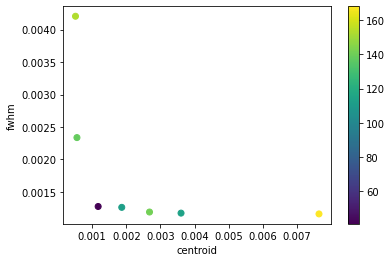

In [29]:
plt.scatter(xvals, yvals, c=idxs)
plt.xlabel('centroid')
plt.ylabel('fwhm')
plt.colorbar()

dict_values([-0.006367500067747542, 0.006428044677235994, -0.01711221093064595, -0.013535341775771738, -0.003958874206107006, 0.007747101208291715, 0.003498294619636879, 0.007636444287762658])


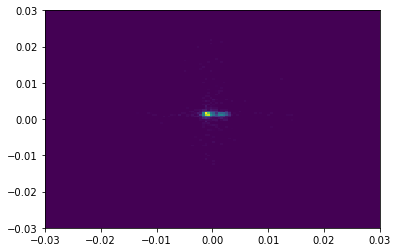

dict_values([0.005117418683078322, 0.008689538540816506, -0.015811181890463107, -0.015024050977399481, -0.0077792008288849026, 0.005603166782077848, 0.0009344851438581742, 0.003539705381480131])


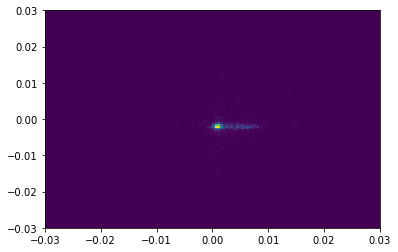

dict_values([-0.01852387107311268, 0.006428044677235994, -0.01711221093064595, 0.013295709938121712, -0.004120199263004465, 0.007747101208291715, -0.002935718120119157, 0.007636444287762658])


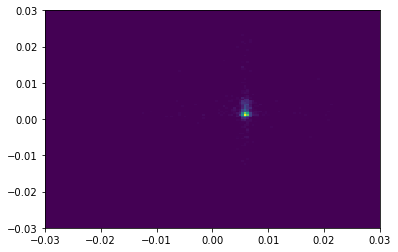

dict_values([0.0031020510714985204, -0.008085120320365307, -0.01711221093064595, 0.0014287960600592002, -0.0020920574510532725, 0.0036674493908030303, 0.003498294619636879, 0.003539705381480131])


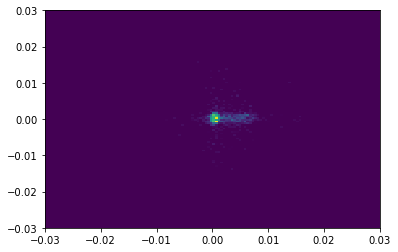

dict_values([-0.01967299242512186, 0.007367326624450103, -0.012236060081261421, -0.014316495768826844, 0.0037426201722246272, 0.0016561916339226917, 0.0003510762663945892, 0.00319524122336025])


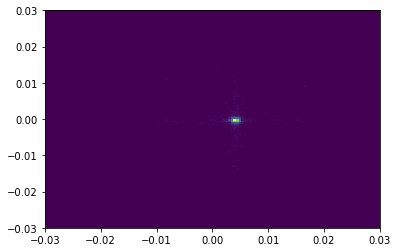

dict_values([0.005117418683078322, -1.694373568207272e-05, -0.00977785667693293, 0.0014287960600592002, 0.005398523963045909, -0.0030483187066206877, 0.006891702479344128, 1.6938476211642364e-05])


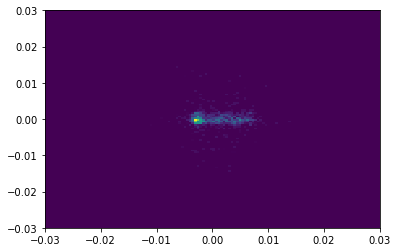

dict_values([-0.006367500067747542, 0.006428044677235994, -0.01711221093064595, -0.013535341775771738, -0.003958874206107006, 0.007747101208291715, 0.003498294619636879, -0.0011875648898318075])


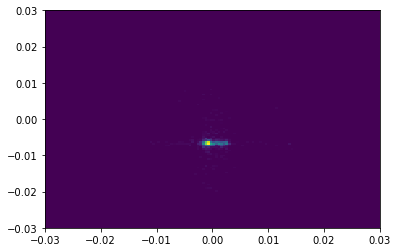

In [30]:
for pars in params:
    opt_trial._lossfn_this(np.array(list(pars)))
    beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED, xrange=[-0.03, 0.03], yrange=[-0.03, 0.03], nbins=128)
    print(pars)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)
    plt.show()

In [31]:
opt_trial._lossfn_this(np.array(list(params[-2])))

[0.0007027590282581755, 0.004738928391451592]